In [19]:
# Update image folder path
path = '/content/drive/My Drive/Covid19action-radiology-CXR_v1.1/images/'
# It is assumed that all the images are in the folder mentioned above and the sources each have all their images in a subfolder of this folder.
# For eg. An image of source 1 is in path+'Source-1/' + image_name

# Update Train label path
label_filename = '/content/drive/My Drive/Covid19action-radiology-CXR_v1.1/Train_Combined_new.csv'

# Update Test label path
test_label_file = '/content/drive/My Drive/Covid19action-radiology-CXR_v1.1/Test_Combined.csv'

#importing all required modules

from google.colab.patches import cv2_imshow
from torch.autograd import Variable
from torch.utils import data
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import os
import time
import sys
import random
import os
import pandas as pd
import csv
import random

#Saving the type of hardware accelertor available, this model was trained using GPU provided by Google Colab
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#The model used for classification
class Model(nn.Module):   # nn.Module --> Base class for all NN modules
    def __init__(self):
        super(Model, self).__init__()
        self.layer1 = torchvision.models.resnet18(pretrained=True, progress=True)
        self.fc1   = nn.Linear(1000, 200)
        self.fc2   = nn.Linear(200, 40)
        self.fc3   = nn.Linear(40, 10)
        self.fc4   = nn.Linear(10, 3)

    def forward(self, x):
        x = self.layer1(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [0]:
#Class MyDataset which is called by the data loader
#The functions defined within the class are named in accordance with the names of functions in the predefined class used by pytorch dataloader.

class MyDataset(data.Dataset):
    def __init__(self, list_IDs, labels, train=True):
        
        self.labels = labels
        self.list_IDs = list_IDs
        self.train = train

    def transform(self, image):
    
        # Resize
        resize = transforms.Resize(size=(224, 224))
        image = resize(image)

        # Transform to tensor
        t = transforms.ToTensor()
        nor = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
        image = t(image)
        image = nor(image)
        return image

    def __getitem__(self, index):
        ID = self.list_IDs[index]
        #image is opened in grayscale by convert('L)
        image = Image.open(ID).convert('RGB')
        # print(image)
        rot = torchvision.transforms.RandomAffine(degrees=15)
        color = transforms.ColorJitter(brightness=.05, contrast=.05, hue=.05, saturation=.05)
        if self.train:
            image = rot(image)
            image = color(image)

        y = self.labels[ID]
        x = self.transform(image)
        return x, y

    def __len__(self):
        return len(self.list_IDs)

In [0]:
def loader(partition, labels, setname, tr):

    params = {'batch_size': 16, 'shuffle': True, 'num_workers': 0}

    train = MyDataset(partition[setname], labels, tr)
    train_loader = data.DataLoader(train, **params)

    return train_loader

In [0]:
def Trainer(net, start_epoch, end_epoch, learning_rate):
    optimizer = optim.Adam(net.parameters(), lr=learning_rate, eps = 1e-8)
    max_acc=0
    cur=-1

    def get_csv_data(csv_fname):
        with open(csv_fname, "r", encoding="utf-8") as csv_records:
            for record in csv.reader(csv_records):
                yield record

    for epoch in range(start_epoch, end_epoch):
        # print(epoch)
        if(epoch%10==0):
            try:
                del train_loader
            except:
                pass
            try:
                del partition
                partition = {}
                partition['train'] = []
            except:
                partition = {}
                partition['train'] = []
            try:
                del labels
                labels = {}
            except:
                labels = {}

            iter_record = iter(get_csv_data(label_filename))
            next(iter_record)  # Skipping the column names
            c=0
            for v,row in enumerate(iter_record,0):
                if(v>cur):
                    a=[]
                    p = True
                    for j in range(3,6):
                        if(row[j] == '-1'):
                            p = False
                        a.append(int(row[j]))
                    if p:
                        a = torch.tensor(a)
                        b = torch.argmax(a)
                        imgpath = path + row[1] + '/' + row[0]
                        if(os.path.exists(imgpath)):
                            partition['train'].append(imgpath)
                            labels[imgpath] = b
                            c+=1
                            if(c>500):
                                cur = v
                                break
            #### Loading data
            train_loader = loader(partition, labels, 'train', True)
            # print(epoch, len(train_loader), cur)
    #     epochStartTime = time.time()
        running_loss = 0.0 
        running_corr = 0
            
        for i,feed in enumerate(train_loader):
            inputs,label = feed
            inputs, label = inputs.to(device),label.to(device) 
            # Initializing model gradients to zero
            net.zero_grad()
            optimizer.zero_grad()
            # Data feed-forward through the network
            outputs = net(inputs)
            # Predicted class is the one with maximum probability
            preds = torch.argmax(outputs,dim=1)
            # Finding the loss
            loss = criterion(outputs, label) 
            # Accumulating the loss for each batch
            running_loss += loss 
            # Accumulate number of correct predictions
            running_corr += torch.sum(preds==label)

        totalLoss = running_loss/(i+1)
        # Calculating gradients
        totalLoss.backward()
        optimizer.step()
        
        epoch_loss = running_loss.item()/(i+1)   #Total loss for one epoch
        epoch_acc = running_corr.item()*100/501
        
        
            
        train_loss.append(epoch_loss) #Saving the loss over epochs for plotting the graph
        train_acc.append(epoch_acc) #Saving the accuracy over epochs for plotting the graph
        print('Epoch {:.0f}/{:.0f} : Training loss: {:.4f} | Training Accuracy: {:.4f}'.format(epoch+1,end_epoch,epoch_loss,epoch_acc))

        

In [7]:
train_loss = []
train_acc = []
net = Model().to(device)
criterion = nn.CrossEntropyLoss()
Trainer(net, 0, 30, 0.001)

Epoch 1/30 : Training loss: 1.0826 | Training Accuracy: 11.3772
Epoch 2/30 : Training loss: 0.9482 | Training Accuracy: 95.4092
Epoch 3/30 : Training loss: 0.7607 | Training Accuracy: 89.0220
Epoch 4/30 : Training loss: 0.5483 | Training Accuracy: 95.4092
Epoch 5/30 : Training loss: 0.3710 | Training Accuracy: 95.4092
Epoch 6/30 : Training loss: 0.2354 | Training Accuracy: 95.4092
Epoch 7/30 : Training loss: 0.1675 | Training Accuracy: 95.4092
Epoch 8/30 : Training loss: 0.1531 | Training Accuracy: 95.4092
Epoch 9/30 : Training loss: 0.1399 | Training Accuracy: 95.4092
Epoch 10/30 : Training loss: 0.1093 | Training Accuracy: 95.4092
Epoch 11/30 : Training loss: 0.2674 | Training Accuracy: 95.6088
Epoch 12/30 : Training loss: 0.1870 | Training Accuracy: 95.4092
Epoch 13/30 : Training loss: 0.1824 | Training Accuracy: 95.6088
Epoch 14/30 : Training loss: 0.1399 | Training Accuracy: 95.6088
Epoch 15/30 : Training loss: 0.1122 | Training Accuracy: 95.6088
Epoch 16/30 : Training loss: 0.108

Training Loss

Training Accuracy


Text(0, 0.5, 'Training')

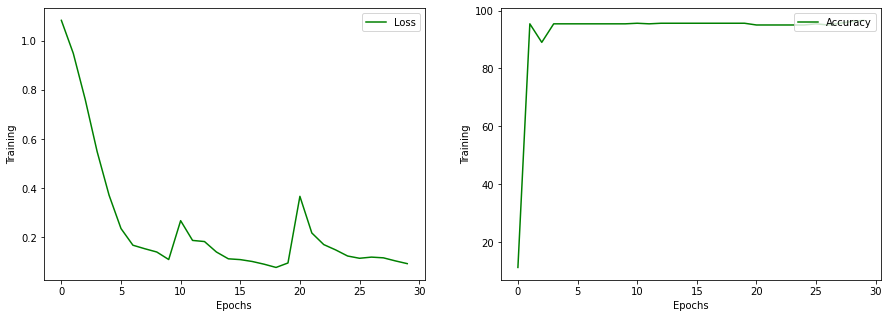

In [8]:
num_epochs=30
print('Training Loss\n')
fig = plt.figure(figsize=[15,5]) 
plt.subplot(121)
plt.plot(range(num_epochs),train_loss,'g-',label='Loss') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Training')

print('Training Accuracy')
plt.subplot(122)
plt.plot(range(num_epochs),train_acc,'g-',label='Accuracy') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Training')

In [0]:
# torch.save(net.state_dict(), '/content/drive/My Drive/Covid/covidmodel.pt')

# del test_loader
# del partition
# del labels

def get_csv_data(csv_fname):
  with open(csv_fname, "r", encoding="utf-8") as csv_records:
    for record in csv.reader(csv_records):
      yield record

iter_record = iter(get_csv_data(filename))
next(iter_record)  # Skipping the column names

partition = {}
partition['test'] = []
labels = {}

temp = {}
part = {}

c=0
# del i

for i,row in enumerate(iter_record, 0):
    # print(i)
    if(i>100000):
        a=[]
        p = True
        for j in range(3,6):
            if(row[j] == '-1'):
                p = False
            a.append(int(row[j]))
        if p:
            a = torch.tensor(a)
            b = torch.argmax(a)
            imgpath = path + row[1] + '/' + row[0]
            if(os.path.exists(imgpath)):
                partition['test'].append(imgpath)
                labels[imgpath] = b
                c+=1
                if(c>500):
                    break

In [0]:
def Test_accuracy(net):
    def get_csv_data(csv_fname):
        with open(csv_fname, "r", encoding="utf-8") as csv_records:
            for record in csv.reader(csv_records):
                yield record

    iter_record = iter(get_csv_data(test_label_file))
    next(iter_record)  # Skipping the column names

    partition = {}
    partition['test'] = []
    labels = {}
    c=0
    for i,row in enumerate(iter_record, 0):
        # if(i>100000):
        a=[]
        p = True
        for j in range(2,5):
            if(row[j] == '-1'):
                p = False
            a.append(int(row[j]))
        if p:
            a = torch.tensor(a)
            b = torch.argmax(a)
            imgpath = path + row[1] + '/' + row[0]
            if(os.path.exists(imgpath)):
                partition['test'].append(imgpath)
                labels[imgpath] = b
                c+=1
                if(c>500):
                    break
    test_loader = loader(partition, labels, 'test', True)
    running_loss = 0.0 
    running_corr = 0
    criterion = nn.CrossEntropyLoss()
    for i,feed in enumerate(test_loader):
                inputs,label = feed
                inputs, label = inputs.to(device),label.to(device) 
                # Initializing model gradients to zero
                net.zero_grad()
                # Data feed-forward through the network
                outputs = net(inputs)
                # Predicted class is the one with maximum probability
                preds = torch.argmax(outputs,dim=1)
                # Finding the loss
                loss = criterion(outputs, label) 
                # Accumulating the loss for each batch
                running_loss += loss 
                # Accumulate number of correct predictions
                running_corr += torch.sum(preds==label)

    totalLoss = running_loss/(i+1)

    epoch_loss = running_loss.item()/(i+1)   #Total loss for one epoch
    epoch_acc = running_corr.item()*100/c


    print('Test loss: {:.4f} | Test Accuracy: {:.4f}'.format(epoch_loss,epoch_acc))


In [0]:
torch.save(net.state_dict(), '/content/drive/My Drive/Covid/covidmodel19.pt')

In [0]:
net = Model().to(device)
net.load_state_dict(torch.load('/content/drive/My Drive/Covid/covidmodel19.pt'))
Test_accuracy(net)

In [3]:
# Calculating number of parameters

tensor_dict = torch.load('/content/drive/My Drive/Covid/covidmodel1.pt', map_location='cuda:0') # OrderedDict
tensor_list = list(tensor_dict.items())
total_param = 0
for layer_tensor_name, tensor in tensor_list:
    print('Layer {}: {} elements'.format(layer_tensor_name, torch.numel(tensor)))
    total_param += torch.numel(tensor)
print('Total Parameters: ', total_param)

Layer layer1.conv1.weight: 9408 elements
Layer layer1.bn1.weight: 64 elements
Layer layer1.bn1.bias: 64 elements
Layer layer1.bn1.running_mean: 64 elements
Layer layer1.bn1.running_var: 64 elements
Layer layer1.bn1.num_batches_tracked: 1 elements
Layer layer1.layer1.0.conv1.weight: 36864 elements
Layer layer1.layer1.0.bn1.weight: 64 elements
Layer layer1.layer1.0.bn1.bias: 64 elements
Layer layer1.layer1.0.bn1.running_mean: 64 elements
Layer layer1.layer1.0.bn1.running_var: 64 elements
Layer layer1.layer1.0.bn1.num_batches_tracked: 1 elements
Layer layer1.layer1.0.conv2.weight: 36864 elements
Layer layer1.layer1.0.bn2.weight: 64 elements
Layer layer1.layer1.0.bn2.bias: 64 elements
Layer layer1.layer1.0.bn2.running_mean: 64 elements
Layer layer1.layer1.0.bn2.running_var: 64 elements
Layer layer1.layer1.0.bn2.num_batches_tracked: 1 elements
Layer layer1.layer1.1.conv1.weight: 36864 elements
Layer layer1.layer1.1.bn1.weight: 64 elements
Layer layer1.layer1.1.bn1.bias: 64 elements
Layer la